# KTR Example

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite, KTR

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand
from orbit.utils.at_temp_dist import StudentTAT

In [26]:
orbit.__version__

'1.1.1dev'

## Data

In [27]:
df = load_iclaims()

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)

df.head()

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.21988,-0.31845,0.11750,-0.41763,0.12265
1,2010-01-10,13.62422,0.21988,-0.19484,0.16879,-0.42548,0.11044
2,2010-01-17,13.39874,0.23614,-0.29248,0.11750,-0.46523,0.53234
3,2010-01-24,13.13755,0.20335,-0.19484,0.10692,-0.48175,0.42864
4,2010-01-31,13.19676,0.13436,-0.24247,0.07448,-0.48893,0.48740


In [28]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2010-01-03 00:00:00
ends with 2018-06-24 00:00:00
shape: (443, 7)


In [29]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

## KTR

### KTR - Full

### zero regression_segments

In [34]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
        regressor_col=['trend.unemploy'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    regression_segments=0,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1,
    ktrlite_optim_args = dict()
)

In [35]:
ktr.fit(train_df)

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .
INFO:orbit:Using SVI(Pyro) with steps:1000 , samples:1000 , learning rate:0.1, learning_rate_total_decay:1.0 and particles:100.
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = -129.28, scale = 0.08837
INFO:orbit:step  100 loss = -352.57, scale = 0.03726
INFO:orbit:step  200 loss = -351.47, scale = 0.034317
INFO:orbit:step  300 loss = -352.31, scale = 0.037732
INFO:orbit:step  400 loss = -352.89, scale = 0.036369
INFO:orbit:step  500 loss = -354.05, scale = 0.036469
INFO:orbit:step  600 loss = -354.12, scale = 0.038294
INFO:orbit:step  700 loss = -351.81, scale = 0.039109
INFO:orbit:step  800 loss = -355.12, scale = 0.037118
INFO:orbit:step  900 loss = -353.15, scale = 0.037624


In [8]:
coef_df = ktr.get_regression_coefs()
coef_df

,week,trend.unemploy
0,2010-01-03,0.09653
1,2010-01-10,0.09653
2,2010-01-17,0.09653
3,2010-01-24,0.09653
4,2010-01-31,0.09653
...,...,...
386,2017-05-28,0.09653
387,2017-06-04,0.09653
388,2017-06-11,0.09653
389,2017-06-18,0.09653


In [9]:
knot_df = ktr.get_regression_coef_knots()
knot_df

,week,step,trend.unemploy
0,2010-01-03,0,0.09653


In [10]:
ktr.get_regression_coefs().head()

,week,trend.unemploy
0,2010-01-03,0.09653
1,2010-01-10,0.09653
2,2010-01-17,0.09653
3,2010-01-24,0.09653
4,2010-01-31,0.09653


In [11]:
ktr.get_regression_coef_knots()

,week,step,trend.unemploy
0,2010-01-03,0,0.09653


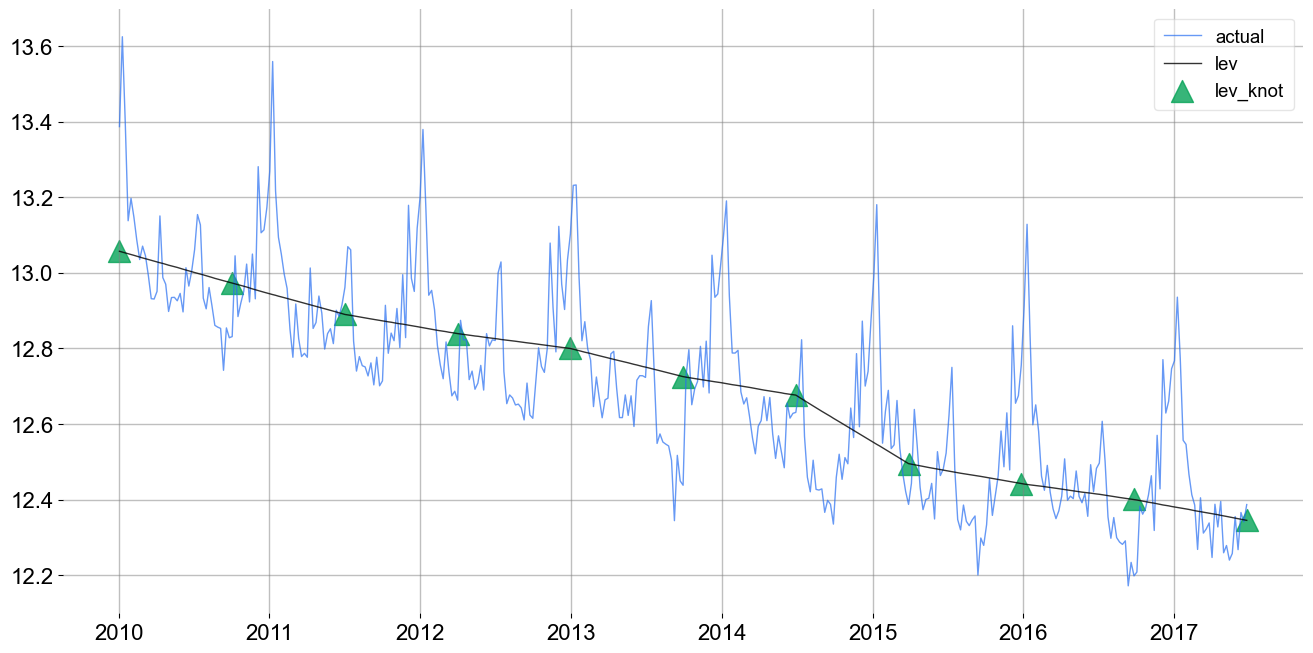

In [12]:
ktr.plot_lev_knots(figsize=(16, 8));

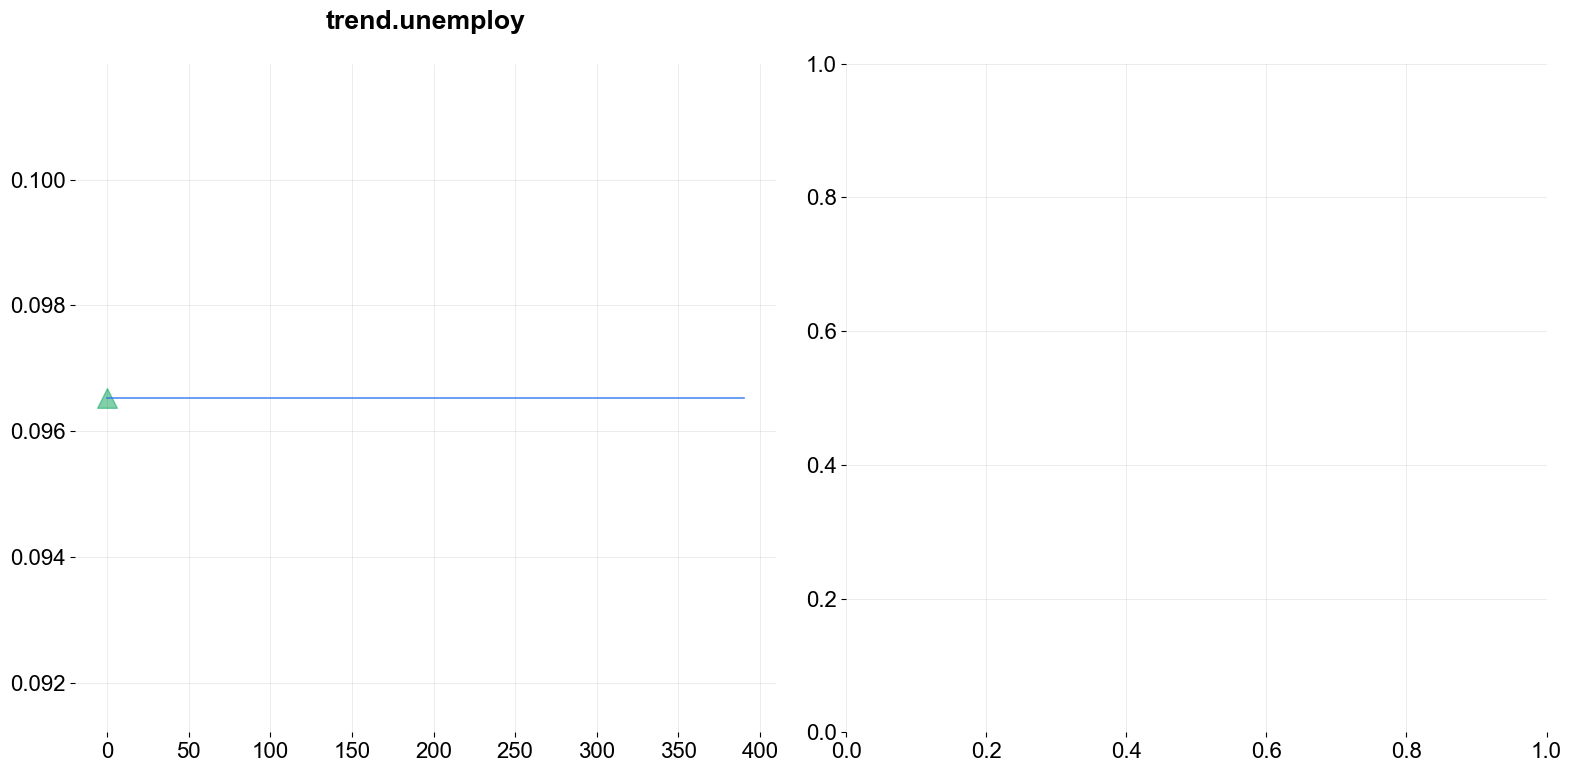

In [13]:
ktr.plot_regression_coefs(with_knot=True, include_ci=False, figsize=(16, 8));

In [14]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,regression_5,regression,regression_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.18674,12.34466,12.50898,12.18138,12.33745,12.50050,0.01329,0.02123,0.02894,-0.01367,-0.01367,-0.01367
1,2017-07-09,12.19311,12.35454,12.50465,12.19271,12.35026,12.50263,0.01524,0.02434,0.03319,-0.02090,-0.02090,-0.02090
2,2017-07-16,12.17019,12.32331,12.49775,12.18430,12.33771,12.51030,0.01127,0.01801,0.02455,-0.03211,-0.03211,-0.03211
3,2017-07-23,12.14305,12.31592,12.46666,12.17380,12.34777,12.49755,0.01024,0.01636,0.02230,-0.04732,-0.04732,-0.04732
4,2017-07-30,12.13637,12.29054,12.45037,12.18249,12.33905,12.50050,0.01127,0.01801,0.02455,-0.06621,-0.06621,-0.06621


In [15]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.73%'

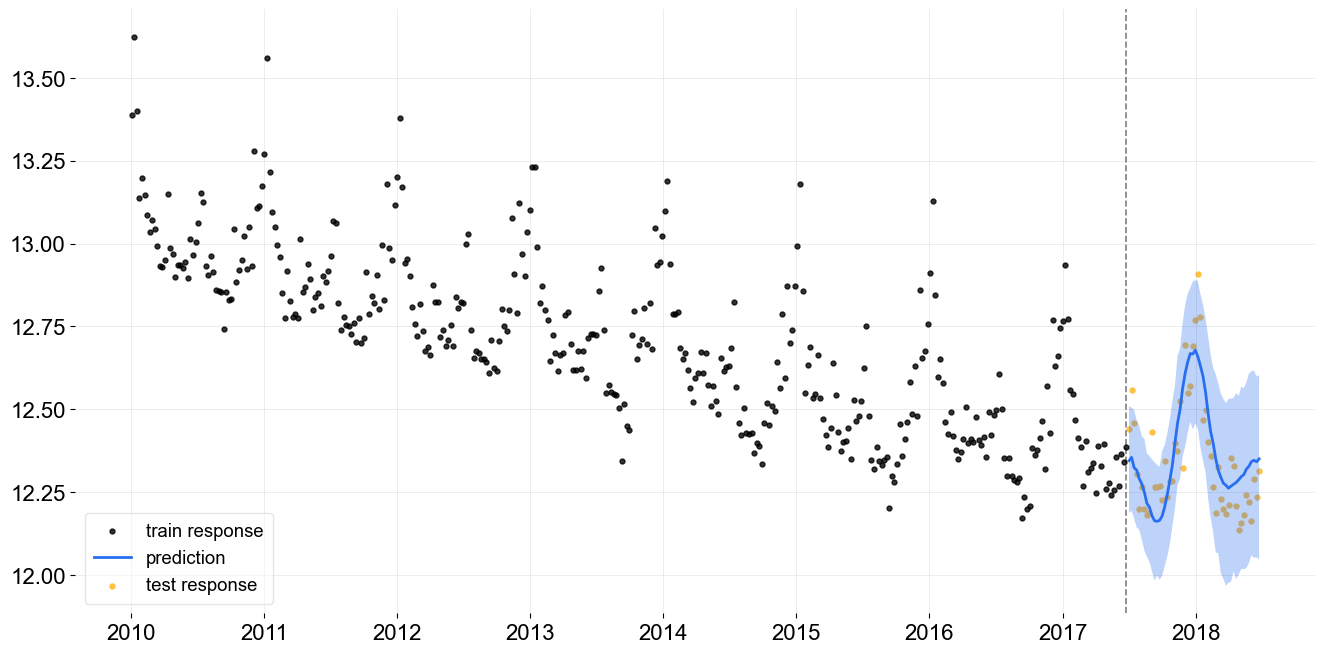

In [16]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

### multiple regression_segments

Change `regression_segments=0` args to `regression_segments=5`.

In [18]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    # regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_col=['trend.unemploy'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1,
    ktrlite_optim_args = dict()
)

In [19]:
ktr.fit(train_df)

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .
INFO:orbit:Using SVI(Pyro) with steps:1000 , samples:1000 , learning rate:0.1, learning_rate_total_decay:1.0 and particles:100 .
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = -122.05, scale = 0.084961
INFO:orbit:step  100 loss = -352.24, scale = 0.046498
INFO:orbit:step  200 loss = -354.46, scale = 0.050182
INFO:orbit:step  300 loss = -352.78, scale = 0.048628
INFO:orbit:step  400 loss = -349.38, scale = 0.049816
INFO:orbit:step  500 loss = -351.55, scale = 0.049404
INFO:orbit:step  600 loss = -350.36, scale = 0.049911
INFO:orbit:step  700 loss = -352.88, scale = 0.050363
INFO:orbit:step  800 loss = -353.24, scale = 0.050048
INFO:orbit:step  900 loss = -351.19, scale = 0.049696


In [20]:
ktr.get_regression_coefs().head()

,week,trend.unemploy
0,2010-01-03,0.10386
1,2010-01-10,0.10377
2,2010-01-17,0.10367
3,2010-01-24,0.10357
4,2010-01-31,0.10348


In [21]:
ktr.get_regression_coef_knots()

,week,step,trend.unemploy
0,2010-01-03,0,0.11035
1,2011-07-03,78,0.08710
2,2012-12-30,156,0.11927
3,2014-06-29,234,0.06504
4,2015-12-27,312,0.09255
5,2017-06-25,390,0.13490


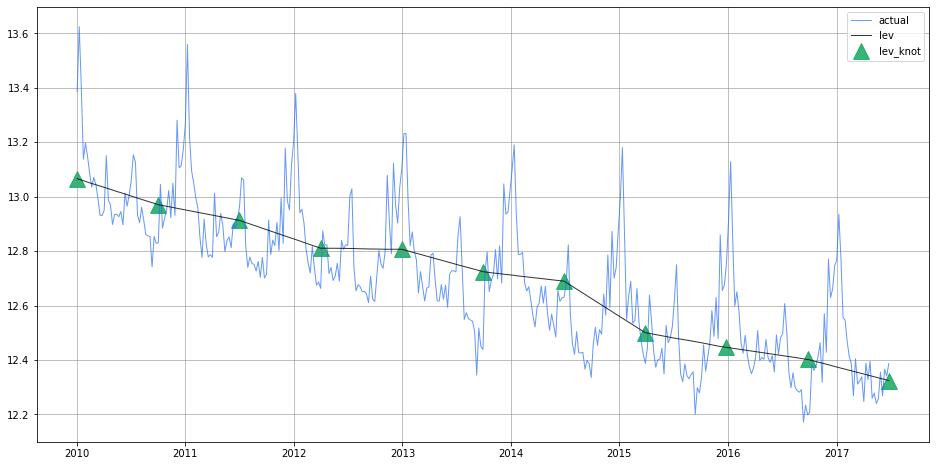

In [22]:
ktr.plot_lev_knots(figsize=(16, 8), use_orbit_style=False);

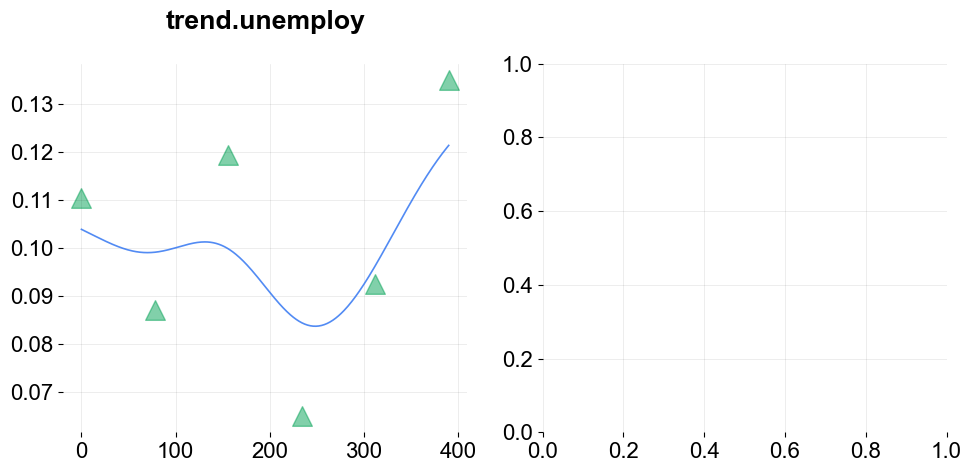

In [23]:
ktr.plot_regression_coefs(with_knot=True, figsize=(10, 5), include_ci=False);

In [24]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,regression_5,regression,regression_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.17602,12.33509,12.49622,12.16346,12.32028,12.48274,0.00148,0.02692,0.05021,-0.01367,-0.01367,-0.01367
1,2017-07-09,12.17908,12.33787,12.48704,12.16675,12.32876,12.48605,0.00170,0.03087,0.05757,-0.02090,-0.02090,-0.02090
2,2017-07-16,12.15634,12.31097,12.47849,12.16617,12.32353,12.48354,0.00126,0.02284,0.04260,-0.03211,-0.03211,-0.03211
3,2017-07-23,12.13226,12.29340,12.45650,12.15828,12.31989,12.48232,0.00114,0.02075,0.03869,-0.04732,-0.04732,-0.04732
4,2017-07-30,12.12414,12.27593,12.43266,12.16706,12.32113,12.47936,0.00126,0.02284,0.04260,-0.06621,-0.06621,-0.06621


In [25]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.71%'

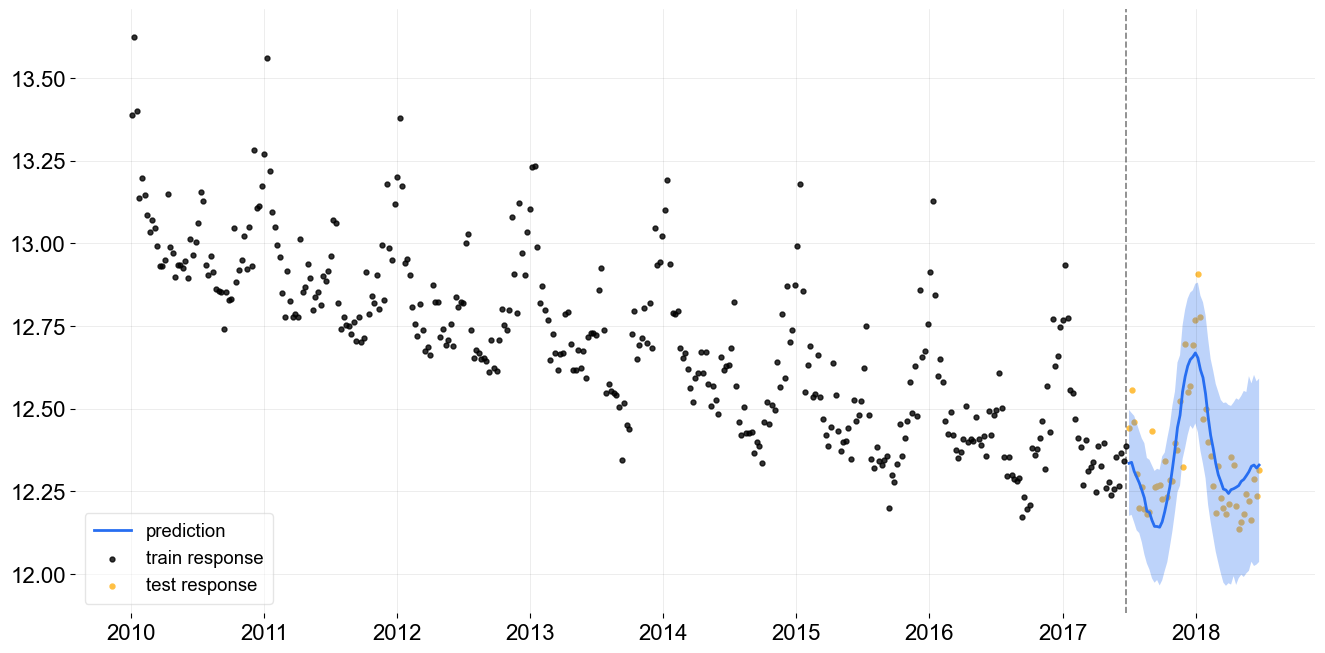

In [26]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

In [27]:
knot_df = ktr.get_regression_coef_knots()
knot_df

,week,step,trend.unemploy
0,2010-01-03,0,0.11035
1,2011-07-03,78,0.08710
2,2012-12-30,156,0.11927
3,2014-06-29,234,0.06504
4,2015-12-27,312,0.09255
5,2017-06-25,390,0.13490


### KTR - Median

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .
INFO:orbit:Using SVI(Pyro) with steps:1000 , samples:1000 , learning rate:0.1, learning_rate_total_decay:1.0 and particles:100 .
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 31.752, scale = 0.096946
INFO:orbit:step  100 loss = -346.54, scale = 0.073014
INFO:orbit:step  200 loss = -347.01, scale = 0.072465
INFO:orbit:step  300 loss = -348.48, scale = 0.073846
INFO:orbit:step  400 loss = -345.43, scale = 0.073653
INFO:orbit:step  500 loss = -344.18, scale = 0.072283
INFO:orbit:step  600 loss = -345.95, scale = 0.07405
INFO:orbit:step  700 loss = -346.15, scale = 0.073452
INFO:orbit:step  800 loss = -343.87, scale = 0.076183
INFO:orbit:step  900 loss = -344.45, scale = 0.074191


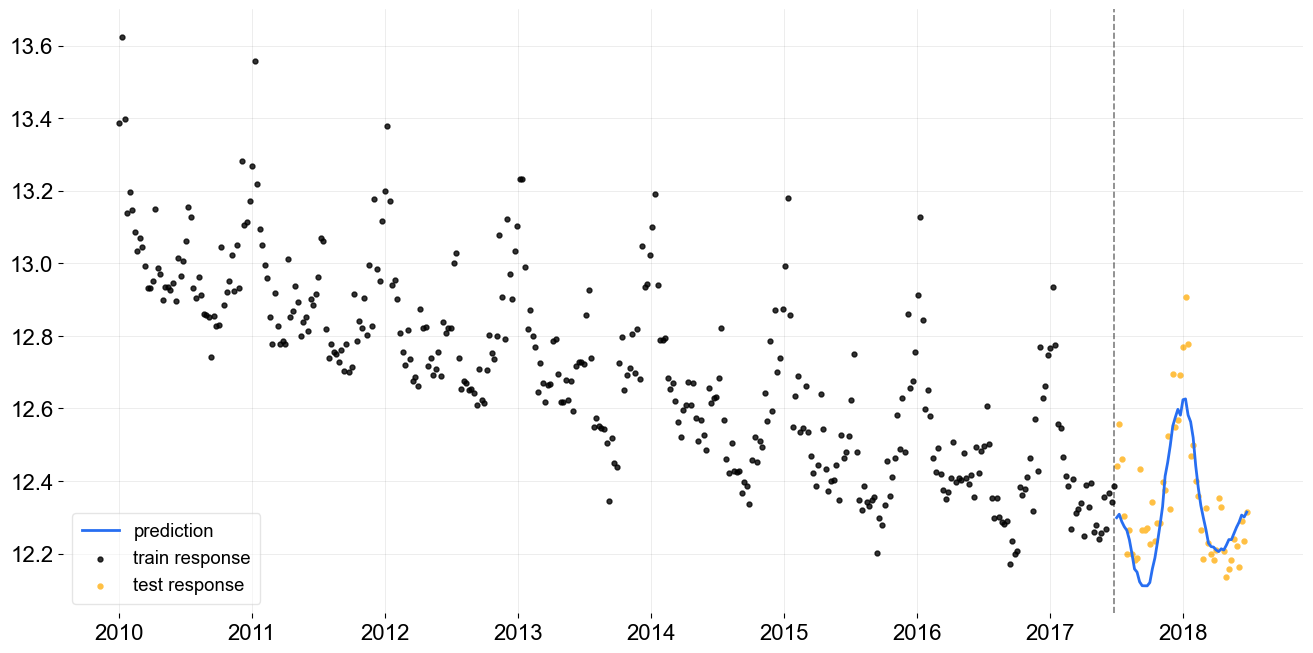

In [28]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=2,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

ktr.fit(df=train_df, point_method='median')
ktr.get_regression_coefs().head()

predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

## Electricity data (dual seasoanlity, no regressor)

In [29]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

df['electricity'] = np.log(df['electricity'])

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [30]:
test_size = 365

train_df = df[:-test_size]
test_df = df[-test_size:]

In [31]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=20,
    seasonality_segments=3,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

In [32]:
ktr.fit(df=train_df, point_method='median')

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .
INFO:orbit:Using SVI(Pyro) with steps:1000 , samples:1000 , learning rate:0.1, learning_rate_total_decay:1.0 and particles:100 .
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = -2427.7, scale = 0.081873
INFO:orbit:step  100 loss = -4735.7, scale = 0.0060206
INFO:orbit:step  200 loss = -4709.7, scale = 0.00632
INFO:orbit:step  300 loss = -4652.6, scale = 0.006399
INFO:orbit:step  400 loss = -4574.9, scale = 0.0064561
INFO:orbit:step  500 loss = -4710.8, scale = 0.0063456
INFO:orbit:step  600 loss = -4674.2, scale = 0.0064545
INFO:orbit:step  700 loss = -4689.3, scale = 0.006469
INFO:orbit:step  800 loss = -4655.4, scale = 0.0062099
INFO:orbit:step  900 loss = -4657.3, scale = 0.0063414


In [33]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

,date,prediction,trend,regression,seasonality_7,seasonality_365.25
360,2008-12-27,9.97291,9.99328,0.00000,-0.02937,0.00900
361,2008-12-28,9.91402,9.99328,0.00000,-0.08773,0.00846
362,2008-12-29,9.97976,9.99328,0.00000,-0.02162,0.00810
363,2008-12-30,10.04459,9.99328,0.00000,0.04336,0.00794
364,2008-12-31,10.02630,9.99328,0.00000,0.02505,0.00797


In [34]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.49%'

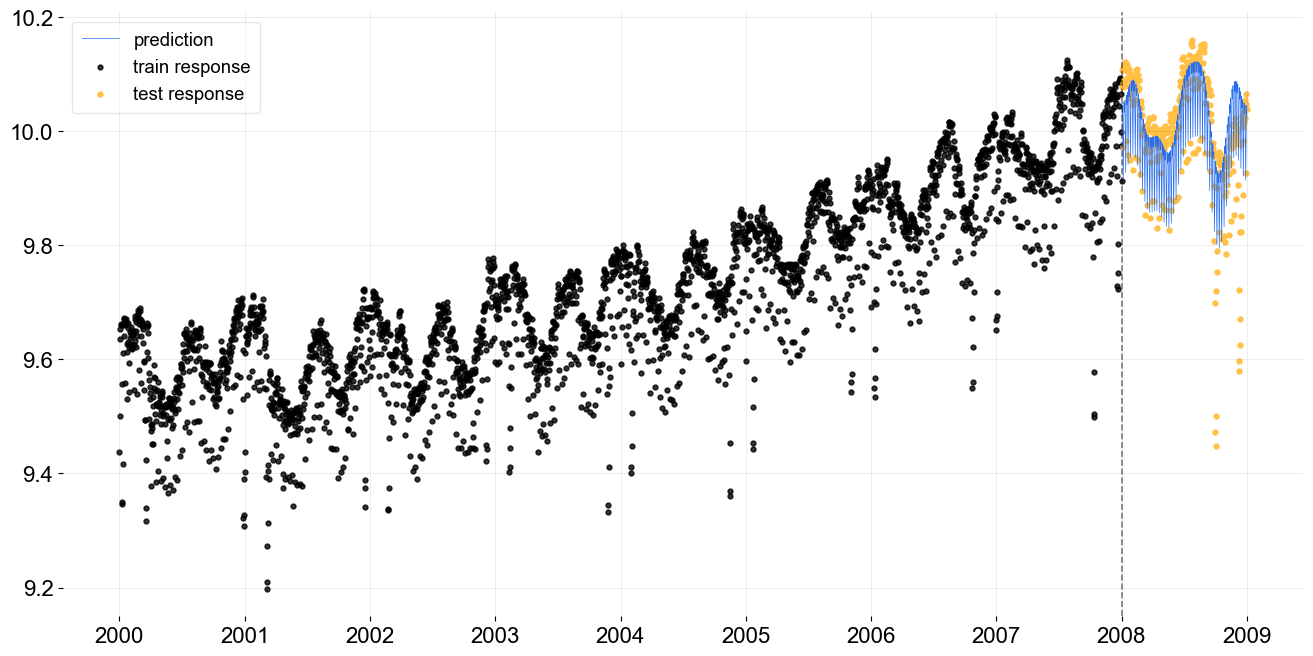

In [35]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                       lw=0.5)